In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [36]:
import pandas as pd

file_path = '/content/drive/MyDrive/[23-2] GCP/fulldata_07_24_04_P_일반음식점.csv'  # CSV 파일 경로
df = pd.read_csv(file_path,  encoding='cp949')
file_1_path = '/content/drive/MyDrive/[23-2] GCP/fulldata_07_24_05_P_휴게음식점.csv'  # CSV 파일 경로
df_1 = pd.read_csv(file_1_path,  encoding='cp949')

merged_df = pd.concat([df, df_1], axis=0)

<ipython-input-36-39a623c321c6>:4: DtypeWarning: Columns (11,27,39,41,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,  encoding='cp949')
<ipython-input-36-39a623c321c6>:6: DtypeWarning: Columns (11,39,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv(file_1_path,  encoding='cp949')


In [37]:
merged_df.head()

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,공장생산직직원수,건물소유구분명,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지,Unnamed: 47
0,1,일반음식점,07_24_04_P,3930000,5560000-101-2023-00271,2023-09-22,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,0.0,NaN,NaN,NaN,NaN
1,2,일반음식점,07_24_04_P,4710000,4710000-101-2023-00096,2023-09-22,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,9.0,NaN,NaN,NaN,NaN
2,3,일반음식점,07_24_04_P,3740000,3770000-101-2023-00341,2023-09-22,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,0.0,NaN,NaN,NaN,NaN
3,4,일반음식점,07_24_04_P,3740000,3770000-101-2023-00339,2023-09-22,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,0.0,NaN,NaN,NaN,NaN
4,5,일반음식점,07_24_04_P,4221000,4221000-101-2023-00058,2023-09-22,NaN,3,폐업,2,...,0.0,NaN,0.0,0.0,N,0.0,NaN,NaN,NaN,NaN


In [38]:
merged_df['인허가일자'] = pd.to_datetime(merged_df['인허가일자'], errors='coerce')
merged_df['년월'] = merged_df['인허가일자'].dt.to_period('M')

## 스테디 아이템 폐업률
    - 누적 폐업률: (일자별 누적 폐업 가게 수 / 일자별 누적 개업 가게 수)*100

### 설빙

In [39]:
name_df = merged_df[merged_df['사업장명'].str.contains('설빙', na=False)]
name_df = name_df[name_df['년월'] >= '2010-01'] # 1호점 개업 날짜

In [40]:
def closure_rate_df(merged_df, start_date):
    # 인허가 일자를 기준으로 월별 개수를 계산
    merged_df['인허가일자'] = pd.to_datetime(merged_df['인허가일자'], errors='coerce')
    license_counts = merged_df['인허가일자'].dt.to_period('M').value_counts().sort_index()

    # 폐업 일자를 기준으로 월별 개수를 계산
    merged_df['폐업일자'] = pd.to_datetime(merged_df['폐업일자'], errors='coerce')
    closure_counts = merged_df['폐업일자'].dt.to_period('M').value_counts().sort_index()

    # 폐업률을 계산하기 위한 데이터프레임 생성
    closure_rate_df = pd.DataFrame({
        '누적 인허가 개수': license_counts.cumsum(),
        '누적 폐업 개수': closure_counts.cumsum()
    })

    # '누적 폐업 개수' 열의 NaN 값을 이전 행의 값으로 채우기
    closure_rate_df['누적 폐업 개수'] = closure_rate_df['누적 폐업 개수'].fillna(method='ffill')
    closure_rate_df['누적 인허가 개수'] = closure_rate_df['누적 인허가 개수'].fillna(method='ffill')

    # 누적 폐업률 계산 (누적 폐업 개수 / 누적 인허가 개수 * 100)
    closure_rate_df['누적 폐업률'] = (closure_rate_df['누적 폐업 개수'] / closure_rate_df['누적 인허가 개수']) * 100

    # 결과 출력
    closure_rate_df.reset_index(inplace=True)
    closure_rate_df.rename(columns={'index': '년월'}, inplace=True)

    closure_rate_df = closure_rate_df[closure_rate_df['년월'] >= start_date] # 붐 시작 날짜

    return closure_rate_df

In [41]:
closure_rate = closure_rate_df(name_df,'2014-07')

In [42]:
closure_rate.tail(10)

,년월,누적 인허가 개수,누적 폐업 개수,누적 폐업률
137,2022-12,631.0,154.0,24.405705
138,2023-01,635.0,156.0,24.566929
139,2023-02,640.0,157.0,24.531250
140,2023-03,643.0,158.0,24.572317
141,2023-04,651.0,160.0,24.577573
142,2023-05,655.0,160.0,24.427481
143,2023-06,662.0,162.0,24.471299
144,2023-07,665.0,164.0,24.661654
145,2023-08,667.0,164.0,24.587706
146,2023-09,668.0,164.0,24.550898


In [43]:
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
max_closure_rate_month

144    2023-07
Name: 년월, dtype: period[M]

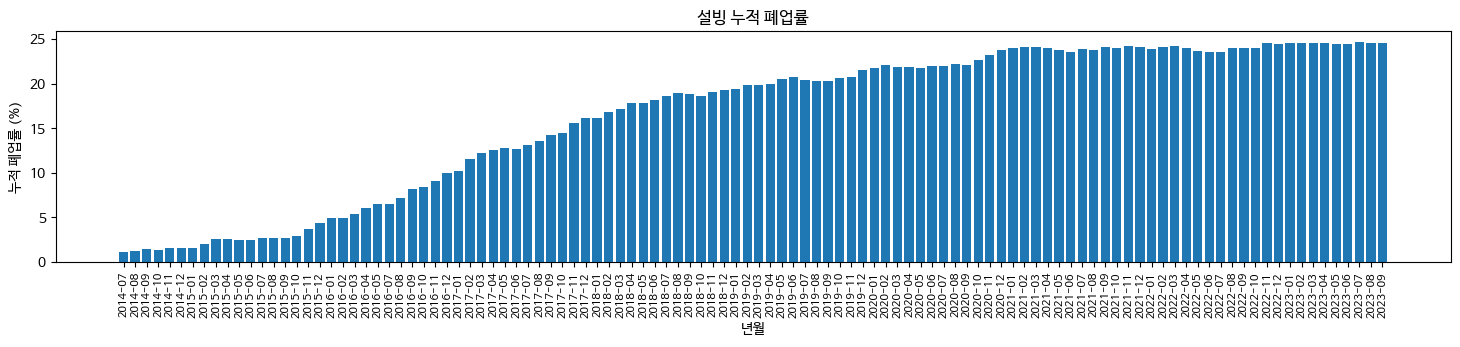

In [44]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumBarunGothic'  # 한글 폰트 설정

# 바 플롯 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('설빙 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

### 공차

<ipython-input-10-84954cf1203d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['인허가일자'] = pd.to_datetime(merged_df['인허가일자'], errors='coerce')
<ipython-input-10-84954cf1203d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['폐업일자'] = pd.to_datetime(merged_df['폐업일자'], errors='coerce')


누적 폐업률 최대값 20.903954802259886
누적 폐업률 최대인 년월 71    2018-09
Name: 년월, dtype: period[M]


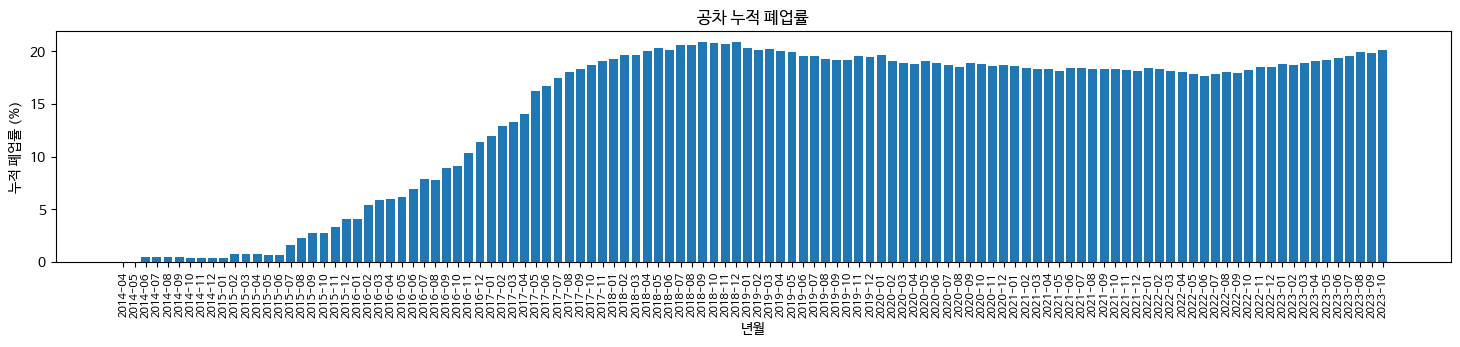

In [15]:
name_df = merged_df[merged_df['사업장명'].str.contains('공차', na=False)]
name_df = name_df[name_df['년월'] >= '2012-04'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2014-04')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('공차 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

In [16]:
closure_rate

,년월,누적 인허가 개수,누적 폐업 개수,누적 폐업률
19,2014-04,174,0.0,0.000000
20,2014-05,185,0.0,0.000000
21,2014-06,197,1.0,0.507614
22,2014-07,210,1.0,0.476190
23,2014-08,219,1.0,0.456621
...,...,...,...,...
128,2023-06,1087,211.0,19.411224
129,2023-07,1094,214.0,19.561243
130,2023-08,1097,219.0,19.963537
131,2023-09,1106,220.0,19.891501


### 핫도그

누적 폐업률 최대값 55.503634475597096
누적 폐업률 최대인 년월 87    2023-10
Name: 년월, dtype: period[M]


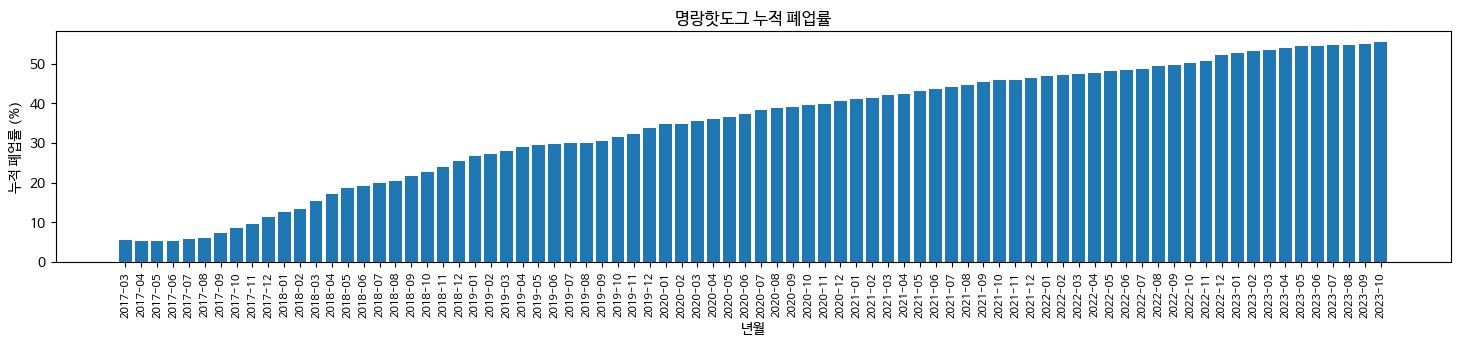

In [60]:
name_df = merged_df[merged_df['사업장명'].str.contains('핫도그', na=False)]
name_df = name_df[name_df['년월'] >= '2016-07'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2017-03')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('명랑핫도그 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

In [18]:
first_over_50 = closure_rate[closure_rate['누적 폐업률'] > 50]['년월'].iloc[0]
print("누적 폐업률이 50을 넘은 첫번째 날:", first_over_50)

누적 폐업률이 50을 넘은 첫번째 날: 2022-10


### 엽떡

누적 폐업률 최대값 10.020449897750511
누적 폐업률 최대인 년월 145    2022-08
Name: 년월, dtype: period[M]


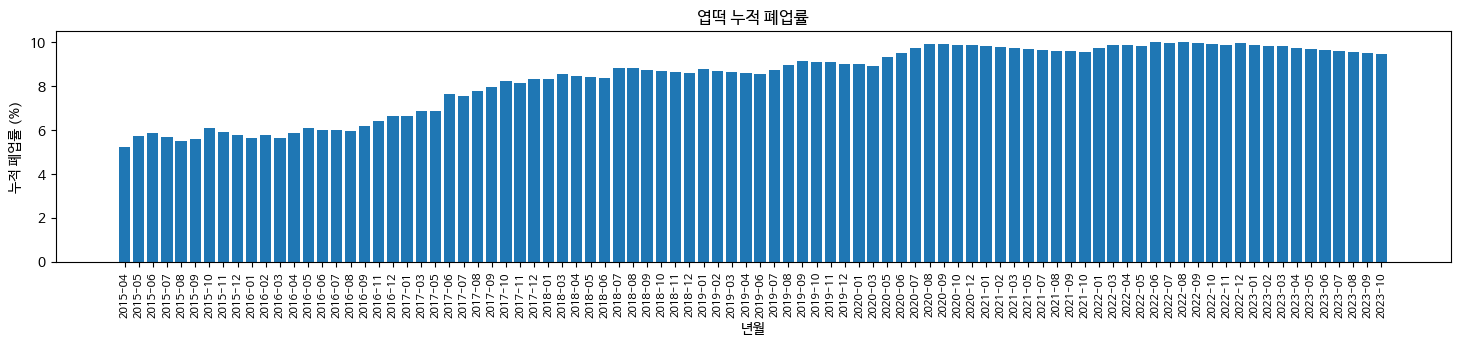

In [19]:
name_df = merged_df[merged_df['사업장명'].str.contains('엽기떡볶이', na=False)]
name_df = name_df[name_df['년월'] >= '2009-01'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2015-04')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('엽떡 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

### 마라탕

누적 폐업률 최대값 14.715235617230412
누적 폐업률 최대인 년월 105    2023-10
Name: 년월, dtype: period[M]


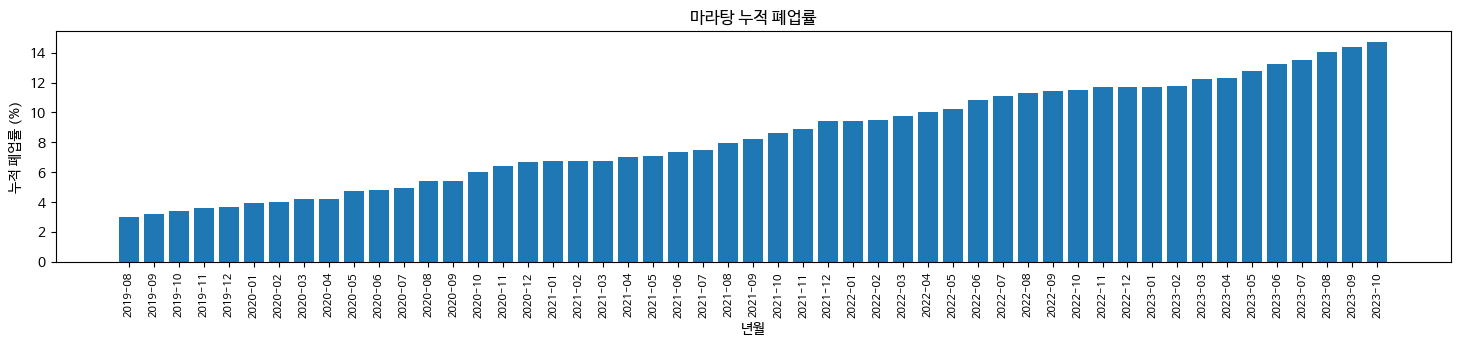

In [20]:
name_df = merged_df[merged_df['사업장명'].str.contains('마라탕', na=False)]
name_df = name_df[name_df['년월'] >= '2015-01'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2019-08')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('마라탕 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

## 트렌디 아이템 폐업률

### 밥버거

누적 폐업률 최대값 65.82914572864321
누적 폐업률 최대인 년월 153    2023-10
Name: 년월, dtype: period[M]


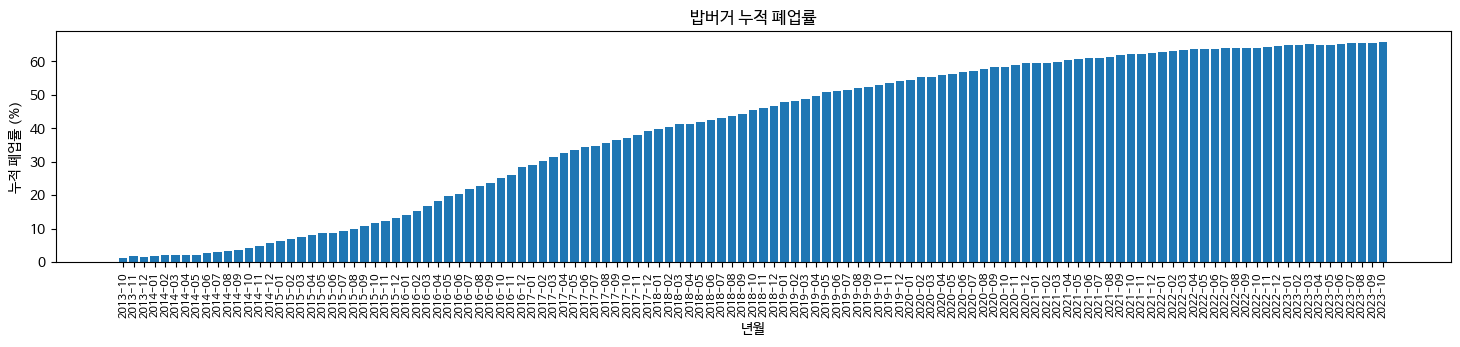

In [47]:
name_df = merged_df[merged_df['사업장명'].str.contains('밥버거', na=False)]
name_df = name_df[name_df['년월'] >= '2011-01'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2013-10')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('밥버거 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

In [22]:
first_over_50 = closure_rate[closure_rate['누적 폐업률'] > 50]['년월'].iloc[0]
print("누적 폐업률이 50을 넘은 첫번째 날:", first_over_50)

누적 폐업률이 50을 넘은 첫번째 날: 2019-05


### 쥬씨

누적 폐업률 최대값 60.75187969924812
누적 폐업률 최대인 년월 136    2023-10
Name: 년월, dtype: period[M]


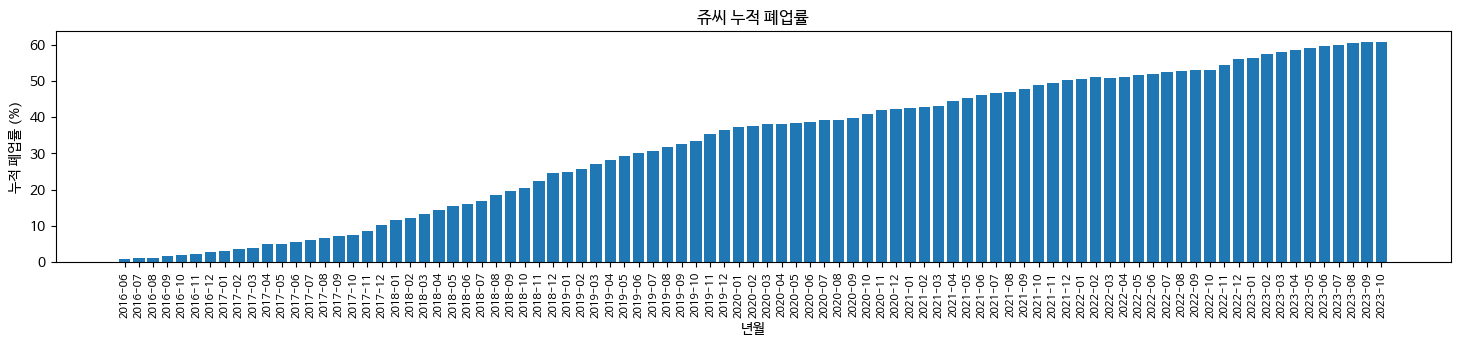

In [50]:
name_df = merged_df[merged_df['사업장명'].str.contains('쥬씨', na=False)]
name_df = name_df[name_df['년월'] >= '2010-09'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2016-06')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('쥬씨 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

In [24]:
first_over_50 = closure_rate[closure_rate['누적 폐업률'] > 50]['년월'].iloc[0]
print("누적 폐업률이 50을 넘은 첫번째 날:", first_over_50)

누적 폐업률이 50을 넘은 첫번째 날: 2019-05


### 카스테라

누적 폐업률 최대값 83.01886792452831
누적 폐업률 최대인 년월 84    2022-11
Name: 년월, dtype: period[M]


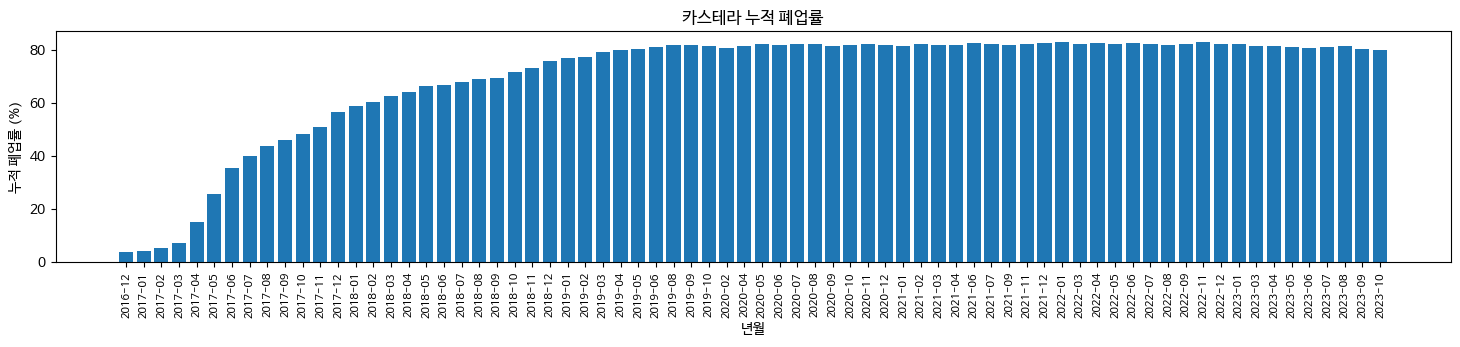

In [53]:
name_df = merged_df[merged_df['사업장명'].str.contains('카스테라', na=False)]
name_df = name_df[name_df['년월'] >= '2014-01'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2016-12')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('카스테라 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

In [54]:
first_over_50 = closure_rate[closure_rate['누적 폐업률'] > 50]['년월'].iloc[0]
print("누적 폐업률이 50을 넘은 첫번째 날:", first_over_50)

누적 폐업률이 50을 넘은 첫번째 날: 2017-11


### 홍루이젠

누적 폐업률 최대값 63.87959866220736
누적 폐업률 최대인 년월 65    2023-10
Name: 년월, dtype: period[M]


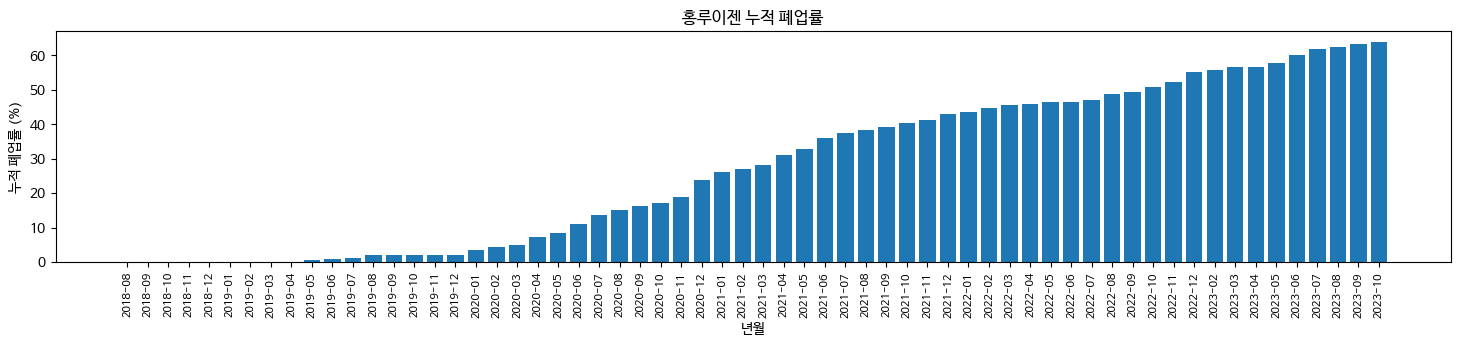

In [57]:
name_df = merged_df[merged_df['사업장명'].str.contains('홍루이젠', na=False)]
name_df = name_df[name_df['년월'] >= '2018-03'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2018-08')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('홍루이젠 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

In [28]:
first_over_50 = closure_rate[closure_rate['누적 폐업률'] > 50]['년월'].iloc[0]
print("누적 폐업률이 50을 넘은 첫번째 날:", first_over_50)

누적 폐업률이 50을 넘은 첫번째 날: 2022-10


### 엉터리 생고기

누적 폐업률 최대값 66.39344262295081
누적 폐업률 최대인 년월 116    2023-10
Name: 년월, dtype: period[M]


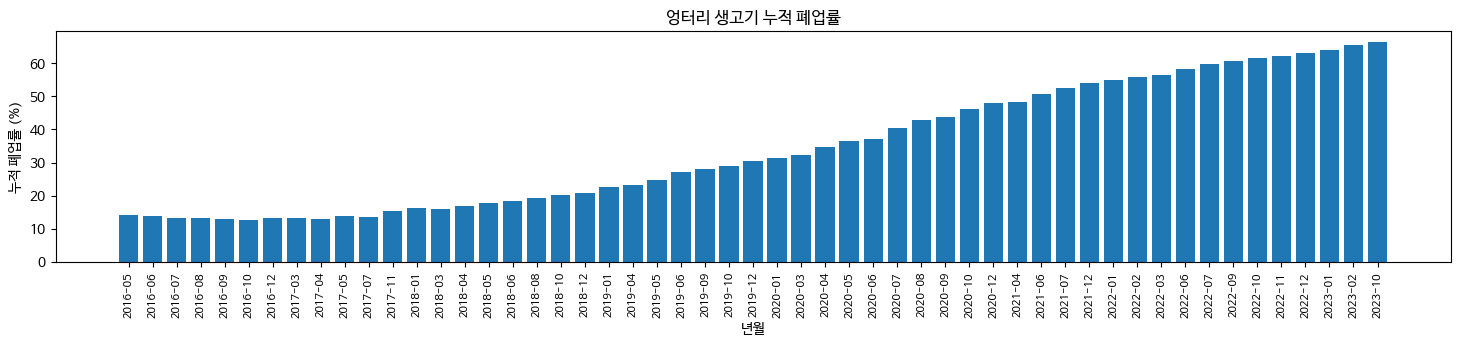

In [29]:
name_df = merged_df[merged_df['사업장명'].str.contains('엉터리생고기', na=False)]
name_df = name_df[name_df['년월'] >= '2006-07'] # 1호점 개업 날짜

closure_rate = closure_rate_df(name_df, '2016-05')
closure_rate.fillna(0, inplace=True)
max_closure_rate_month = closure_rate[closure_rate['누적 폐업률'] == max(closure_rate['누적 폐업률'])]['년월']
print("누적 폐업률 최대값",max(closure_rate['누적 폐업률']))
print("누적 폐업률 최대인 년월",max_closure_rate_month)

# 그래프 그리기
plt.figure(figsize=(18, 3))  # 그래프 크기 설정
plt.bar(closure_rate['년월'].dt.strftime('%Y-%m'), closure_rate['누적 폐업률'])

# 축 레이블 및 제목 설정
plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('엉터리 생고기 누적 폐업률')

# 플롯 표시
plt.xticks(rotation=90, fontsize=8)  # x축 레이블 회전
plt.show()

In [30]:
first_over_50 = closure_rate[closure_rate['누적 폐업률'] > 50]['년월'].iloc[0]
print("누적 폐업률이 50을 넘은 첫번째 날:", first_over_50)

누적 폐업률이 50을 넘은 첫번째 날: 2021-06


## 전체 누적 폐업률 계산

In [31]:
#total_df = merged_df[merged_df['년월'] >= '2013-10'] # 가장 빠른 붐 일자
closure_rate_total = closure_rate_df(merged_df, '2013-10')

### 밥버거와 비교

In [48]:
closure_rate_total_p = closure_rate_total[closure_rate_total['년월'] >= '2013-10']
closure_rate_total_p.head()

,년월,누적 인허가 개수,누적 폐업 개수,누적 폐업률
729,2013-10,1691514.0,996400.0,58.905809
730,2013-11,1697760.0,1000853.0,58.951383
731,2013-12,1703610.0,1006550.0,59.083358
732,2014-01,1708162.0,1010965.0,59.184375
733,2014-02,1713233.0,1015283.0,59.261233


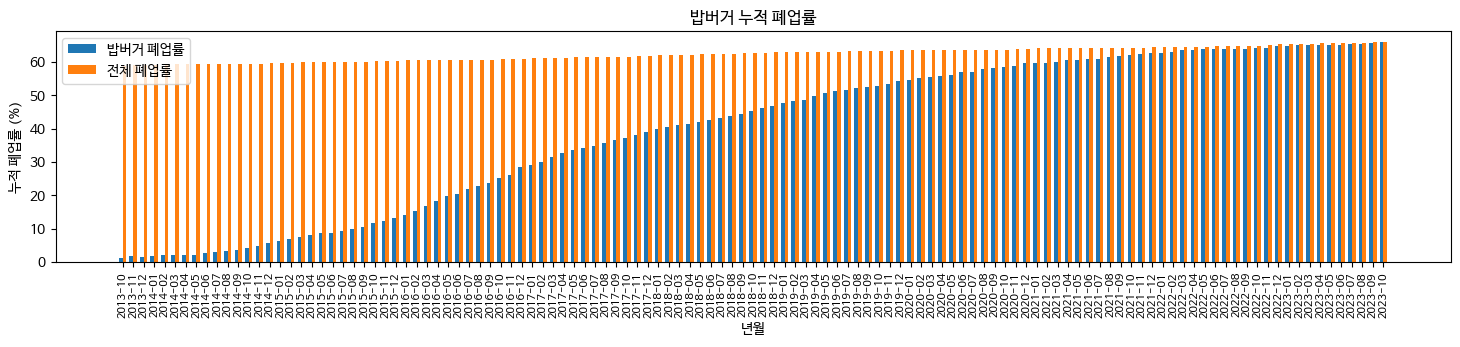

In [49]:
import matplotlib.pyplot as plt
import numpy as np

common_dates = closure_rate['년월'].isin(closure_rate_total['년월'])
closure_rate_common = closure_rate[common_dates]

common_dates_total = closure_rate_total_p['년월'].isin(closure_rate['년월'])
closure_rate_total_common = closure_rate_total_p[common_dates_total]

bar_width = 0.35
index = np.arange(len(closure_rate_common['년월']))

# 그래프 그리기
plt.figure(figsize=(18, 3))

plt.bar(index, closure_rate_common['누적 폐업률'], bar_width, label='밥버거 폐업률')

plt.bar(index + bar_width, closure_rate_total_common['누적 폐업률'], bar_width, label='전체 폐업률')

plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('밥버거 누적 폐업률')

plt.xticks(index + bar_width / 2, closure_rate_common['년월'].dt.strftime('%Y-%m'), rotation=90, fontsize=8)

plt.legend()

plt.show()

### 쥬씨와 비교

In [51]:
closure_rate_total_p = closure_rate_total[closure_rate_total['년월'] >= '2016-06']
closure_rate_total_p.head()

,년월,누적 인허가 개수,누적 폐업 개수,누적 폐업률
761,2016-06,1913740.0,1159947.0,60.611525
762,2016-07,1921563.0,1164880.0,60.621484
763,2016-08,1929116.0,1170399.0,60.670224
764,2016-09,1936645.0,1175857.0,60.716187
765,2016-10,1944786.0,1182114.0,60.783757


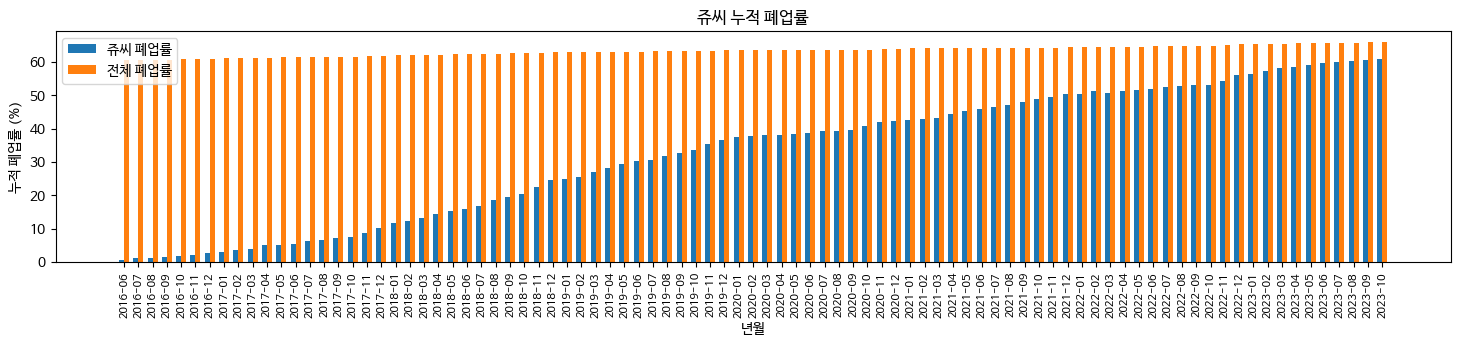

In [52]:
common_dates = closure_rate['년월'].isin(closure_rate_total['년월'])
closure_rate_common = closure_rate[common_dates]

common_dates_total = closure_rate_total_p['년월'].isin(closure_rate['년월'])
closure_rate_total_common = closure_rate_total_p[common_dates_total]

bar_width = 0.35
index = np.arange(len(closure_rate_common['년월']))

# 그래프 그리기
plt.figure(figsize=(18, 3))

plt.bar(index, closure_rate_common['누적 폐업률'], bar_width, label='쥬씨 폐업률')

plt.bar(index + bar_width, closure_rate_total_common['누적 폐업률'], bar_width, label='전체 폐업률')

plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('쥬씨 누적 폐업률')

plt.xticks(index + bar_width / 2, closure_rate_common['년월'].dt.strftime('%Y-%m'), rotation=90, fontsize=8)

plt.legend()

plt.show()

### 카스테라와 비교

In [55]:
closure_rate_total_p = closure_rate_total[closure_rate_total['년월'] >= '2016-12']
closure_rate_total_p.head()

,년월,누적 인허가 개수,누적 폐업 개수,누적 폐업률
767,2016-12,1960705.0,1195799.0,60.988216
768,2017-01,1966514.0,1201520.0,61.098980
769,2017-02,1973247.0,1207182.0,61.177440
770,2017-03,1982274.0,1213920.0,61.238759
771,2017-04,1991128.0,1220137.0,61.278682


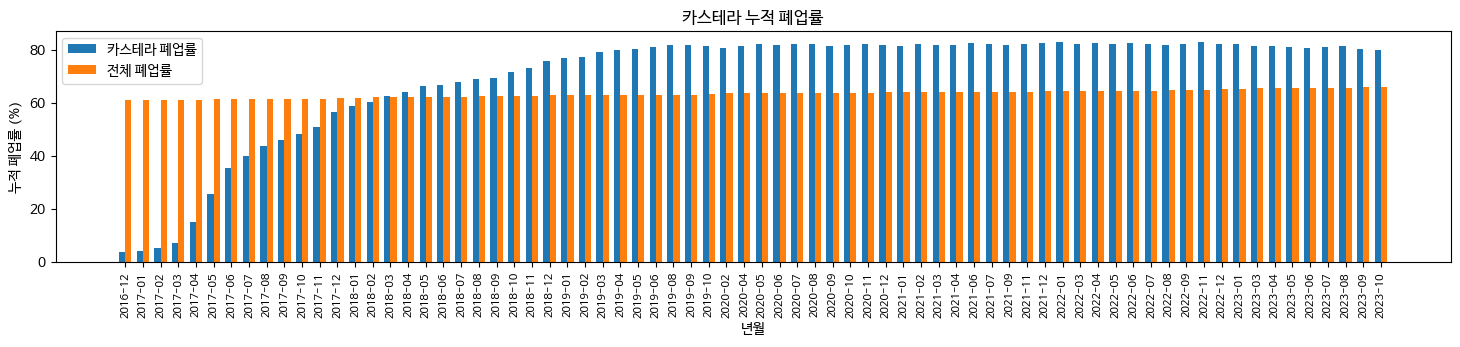

In [56]:
common_dates = closure_rate['년월'].isin(closure_rate_total['년월'])
closure_rate_common = closure_rate[common_dates]

common_dates_total = closure_rate_total_p['년월'].isin(closure_rate['년월'])
closure_rate_total_common = closure_rate_total_p[common_dates_total]

bar_width = 0.35
index = np.arange(len(closure_rate_common['년월']))

# 그래프 그리기
plt.figure(figsize=(18, 3))

plt.bar(index, closure_rate_common['누적 폐업률'], bar_width, label='카스테라 폐업률')

plt.bar(index + bar_width, closure_rate_total_common['누적 폐업률'], bar_width, label='전체 폐업률')

plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('카스테라 누적 폐업률')

plt.xticks(index + bar_width / 2, closure_rate_common['년월'].dt.strftime('%Y-%m'), rotation=90, fontsize=8)

plt.legend()

plt.show()

### 홍루이젠과 비교

In [58]:
closure_rate_total_p = closure_rate_total[closure_rate_total['년월'] >= '2018-08']
closure_rate_total_p.head()

,년월,누적 인허가 개수,누적 폐업 개수,누적 폐업률
787,2018-08,2119575.0,1324761.0,62.501256
788,2018-09,2126926.0,1329931.0,62.528316
789,2018-10,2136704.0,1337175.0,62.581200
790,2018-11,2145384.0,1343667.0,62.630606
791,2018-12,2152745.0,1352386.0,62.821467


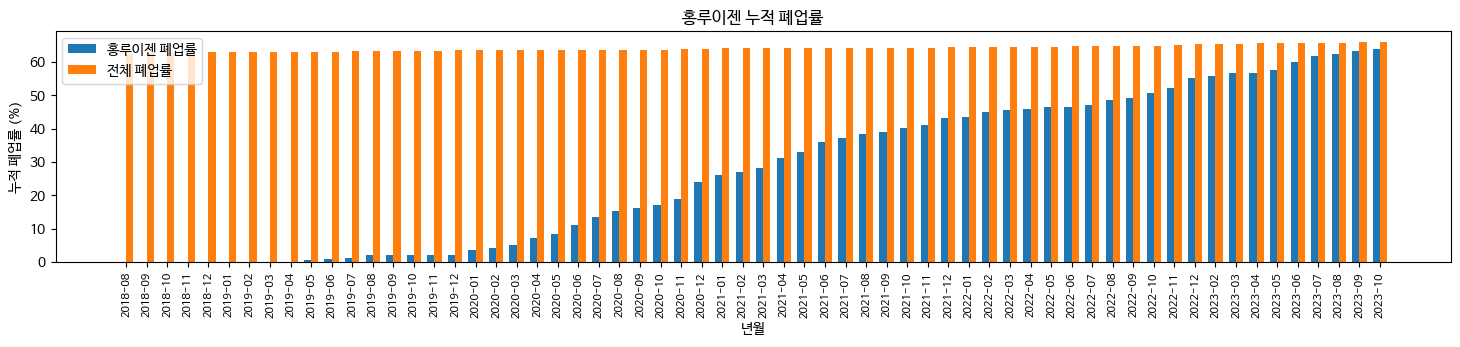

In [59]:
common_dates = closure_rate['년월'].isin(closure_rate_total['년월'])
closure_rate_common = closure_rate[common_dates]

common_dates_total = closure_rate_total_p['년월'].isin(closure_rate['년월'])
closure_rate_total_common = closure_rate_total_p[common_dates_total]

bar_width = 0.35
index = np.arange(len(closure_rate_common['년월']))

# 그래프 그리기
plt.figure(figsize=(18, 3))

plt.bar(index, closure_rate_common['누적 폐업률'], bar_width, label='홍루이젠 폐업률')

plt.bar(index + bar_width, closure_rate_total_common['누적 폐업률'], bar_width, label='전체 폐업률')

plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('홍루이젠 누적 폐업률')

plt.xticks(index + bar_width / 2, closure_rate_common['년월'].dt.strftime('%Y-%m'), rotation=90, fontsize=8)

plt.legend()

plt.show()

### 엉생과 비교

In [32]:
closure_rate_total_p = closure_rate_total[closure_rate_total['년월'] >= '2016-05']
closure_rate_total_p.head()

,년월,누적 인허가 개수,누적 폐업 개수,누적 폐업률
760,2016-05,1905303.0,1154427.0,60.590205
761,2016-06,1913740.0,1159947.0,60.611525
762,2016-07,1921563.0,1164880.0,60.621484
763,2016-08,1929116.0,1170399.0,60.670224
764,2016-09,1936645.0,1175857.0,60.716187


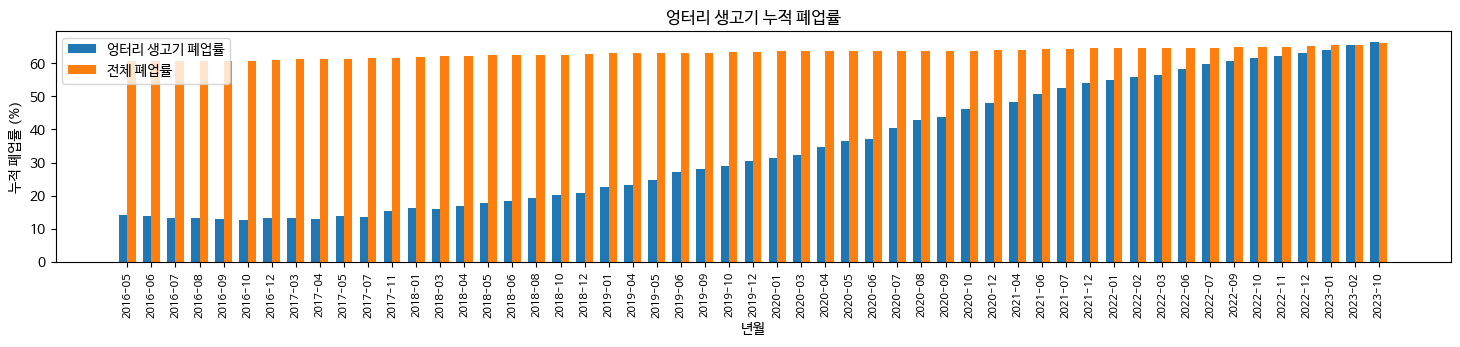

In [33]:
import matplotlib.pyplot as plt
import numpy as np

common_dates = closure_rate['년월'].isin(closure_rate_total['년월'])
closure_rate_common = closure_rate[common_dates]

common_dates_total = closure_rate_total_p['년월'].isin(closure_rate['년월'])
closure_rate_total_common = closure_rate_total_p[common_dates_total]

bar_width = 0.35
index = np.arange(len(closure_rate_common['년월']))

# 그래프 그리기
plt.figure(figsize=(18, 3))

plt.bar(index, closure_rate_common['누적 폐업률'], bar_width, label='엉터리 생고기 폐업률')

plt.bar(index + bar_width, closure_rate_total_common['누적 폐업률'], bar_width, label='전체 폐업률')

plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('엉터리 생고기 누적 폐업률')

plt.xticks(index + bar_width / 2, closure_rate_common['년월'].dt.strftime('%Y-%m'), rotation=90, fontsize=8)

plt.legend()

plt.show()

### (+) 핫도그와 비교

In [61]:
closure_rate_total_p = closure_rate_total[closure_rate_total['년월'] >= '2017-03']
closure_rate_total_p.head()

,년월,누적 인허가 개수,누적 폐업 개수,누적 폐업률
770,2017-03,1982274.0,1213920.0,61.238759
771,2017-04,1991128.0,1220137.0,61.278682
772,2017-05,1999748.0,1226632.0,61.339329
773,2017-06,2008424.0,1232895.0,61.386191
774,2017-07,2016468.0,1238745.0,61.431424


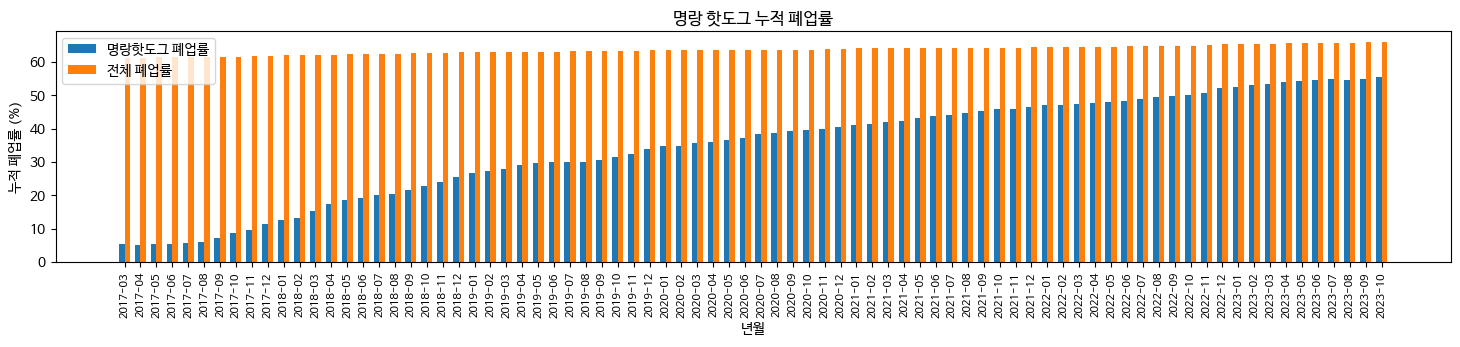

In [62]:
import matplotlib.pyplot as plt
import numpy as np

common_dates = closure_rate['년월'].isin(closure_rate_total['년월'])
closure_rate_common = closure_rate[common_dates]

common_dates_total = closure_rate_total_p['년월'].isin(closure_rate['년월'])
closure_rate_total_common = closure_rate_total_p[common_dates_total]

bar_width = 0.35
index = np.arange(len(closure_rate_common['년월']))

# 그래프 그리기
plt.figure(figsize=(18, 3))

plt.bar(index, closure_rate_common['누적 폐업률'], bar_width, label='명랑핫도그 폐업률')

plt.bar(index + bar_width, closure_rate_total_common['누적 폐업률'], bar_width, label='전체 폐업률')

plt.xlabel('년월')
plt.ylabel('누적 폐업률 (%)')
plt.title('명랑 핫도그 누적 폐업률')

plt.xticks(index + bar_width / 2, closure_rate_common['년월'].dt.strftime('%Y-%m'), rotation=90, fontsize=8)

plt.legend()

plt.show()